In [ ]:
# data for AQI summaries

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
def rename_county_h(df, state):
# df should have "location_name" as the index
# state is string
# remove " county" from the county name, prepend state name
# apply to each state mortality rate file 
    new_index = []
    for old_name in df.index:
    
        end = len(old_name)
        delete = len(" County")
        new = state+"_"+old_name[0:end-delete]
        new_index.append(new.lower())
        
    df.index = new_index
    return df

In [3]:
#get single table from a health file for one state, one code, one year
# df is dataframe of entire health file for one state
# cause of dealth code
def get_single_table_health(df, code, year):

#     get rid of state summaries
    state = df.iloc[0]["location_name"]
    df_h = df[df["FIPS"] >100]
#     select year
    df_h = df_h[df_h['year_id']==year]
    df_h.set_index('location_name',inplace=True)
    
#     select code
    dfc = df_h[df_h["cause_id"] == code]
    
#     organize metadata by county
    df_meta = dfc[['location_id', 'FIPS', 'cause_id', 'cause_name']].drop_duplicates()
        
#     transform mortality rates by gender
    df_genders = pd.pivot_table(dfc, values='mx', index='location_name', columns=['sex'])
    #df_genders.rename(index=str, columns={"Both": "both_gender_resp_mort", "Female": "female_resp_mort", "Male": "male_resp_mort"}, inplace=True)
    df_by_county = pd.concat([df_meta, df_genders], axis=1, join='inner')
    return rename_county_h(df_by_county, state)

In [4]:
# transform the air quality data to be indexed by statename_countyname 
# normalized the air quality metrics by number of days reorded in a location 
def transform_air(df_a):
    # normalize values
    df_a.columns.values
    to_norm = ['Good Days','Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days','Days CO',
       'Days NO2', 'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10']
    
    for c in to_norm:
        df_a[c] = df_a[c]/df_a['Days with AQI']

    df_a["location_name"] = (df_a['State']+"_"+df_a['County']).str.lower()
    df_a.drop(['State','County'], axis=1, inplace=True)
    df_a.set_index('location_name', inplace=True)
    return df_a

In [5]:
directory = 'data'
health_files = []
air_files = []
years = []
joined =pd.DataFrame()

# get health files
for filename in os.listdir(directory):        
    if filename.startswith("IHME"): 
        health_files.append(os.path.join(directory, filename))
        
# all causes 294
# chronic respiratory diseases 508
# cardiovascular diseases 491
# diarhhea, lower respiratory, and other common infectious diseases 301
# unintentional injuries 696



codes = [294, 508, 491, 696, 301]
for c in codes:
    print("compiling code: " + str(c))
    
    # get health data across all states for one year
    for filename in os.listdir(directory):
        if filename.startswith("annual_aqi"):
#             print(filename)
            year = int(filename[len(filename)-8 :len(filename)-4])
#             print(year)
            air_file = os.path.join(directory,filename)
            dfa = transform_air(pd.read_csv(air_file))
#             print("got transformed air file")
        
#           get first table
            df = pd.read_csv(health_files[0])
            df = get_single_table_health(df, c, year)
            
#             print("health file 0")
#             i=1
            for h in health_files[1:]:
#                 print("health file " + str(i))
                df_h = pd.read_csv(h)
                df = df.append(get_single_table_health(df_h, c, year))
#                i+=1
            joined = pd.concat([df, dfa], axis=1, join='inner')
#             print("got joined ")
            print(joined.shape)
            joined.to_csv("data_cleaned/"+str(year)+"_"+str(c)+"_data.csv")
            print("data_cleaned/"+str(year)+"_"+str(c)+"_data.csv")

compiling code: 294
(567, 24)
data_cleaned/1980_294_data.csv
(573, 24)
data_cleaned/1981_294_data.csv
(569, 24)
data_cleaned/1982_294_data.csv
(586, 24)
data_cleaned/1983_294_data.csv
(557, 24)
data_cleaned/1984_294_data.csv
(618, 24)
data_cleaned/1985_294_data.csv
(630, 24)
data_cleaned/1986_294_data.csv
(670, 24)
data_cleaned/1987_294_data.csv
(711, 24)
data_cleaned/1988_294_data.csv
(766, 24)
data_cleaned/1989_294_data.csv
(819, 24)
data_cleaned/1990_294_data.csv
(862, 24)
data_cleaned/1991_294_data.csv
(892, 24)
data_cleaned/1992_294_data.csv
(894, 24)
data_cleaned/1993_294_data.csv
(917, 24)
data_cleaned/1994_294_data.csv
(943, 24)
data_cleaned/1995_294_data.csv
(948, 24)
data_cleaned/1996_294_data.csv
(964, 24)
data_cleaned/1997_294_data.csv
(928, 24)
data_cleaned/1998_294_data.csv
(994, 24)
data_cleaned/1999_294_data.csv
(1050, 24)
data_cleaned/2000_294_data.csv
(1067, 24)
data_cleaned/2001_294_data.csv
(1072, 24)
data_cleaned/2002_294_data.csv
(1079, 24)
data_cleaned/2003_294_d

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [15]:
# append all 508 files into one big table - each row is one county, one year 
#codes = [294, 508, 491, 696, 301]

directory = 'data_cleaned'

# get 508 files
first = True
for filename in os.listdir(directory):
    if first==True and filename.endswith("301_data.csv"): 
        joined = pd.read_csv(os.path.join(directory, filename))
        first = False
    elif filename.endswith("301_data.csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        joined = joined.append(df)
        
joined.reset_index(inplace=True)
joined.shape

joined.to_csv("data_cleaned/301_allcountiesallyears_data.csv")

In [16]:
test = pd.read_csv("data_cleaned/301_allcountiesallyears_data.csv")
test.head()

,Unnamed: 0,index,90th Percentile AQI,Both,Days CO,Days NO2,Days Ozone,Days PM10,Days PM2.5,Days SO2,...,Median AQI,Moderate Days,Unhealthy Days,Unhealthy for Sensitive Groups Days,Unnamed: 0.1,Very Unhealthy Days,Year,cause_id,cause_name,location_id
0,0,0,108,31.592461,0.000000,0.0,0.681564,0.0,0.0,0.318436,...,40,0.195531,0.022346,0.100559,alabama_autauga,0.000000,1980,301,"Diarrhea, lower respiratory, and other common ...",614
1,1,1,165,29.319004,0.000000,0.0,0.000000,0.0,0.0,1.000000,...,56,0.164234,0.142336,0.229927,alabama_colbert,0.000000,1980,301,"Diarrhea, lower respiratory, and other common ...",578
2,2,2,200,36.429936,0.000000,0.0,0.000000,0.0,0.0,1.000000,...,94,0.300546,0.215847,0.251366,alabama_jackson,0.000000,1980,301,"Diarrhea, lower respiratory, and other common ...",577
3,3,3,140,34.281870,0.590643,0.0,0.409357,0.0,0.0,0.000000,...,50,0.307018,0.055556,0.108187,alabama_jefferson,0.020468,1980,301,"Diarrhea, lower respiratory, and other common ...",596
4,4,4,139,32.048989,0.000000,0.0,0.000000,0.0,0.0,1.000000,...,56,0.211679,0.069343,0.281022,alabama_lauderdale,0.000000,1980,301,"Diarrhea, lower respiratory, and other common ...",574


In [17]:
test.columns.values

array(['Unnamed: 0', 'index', '90th Percentile AQI', 'Both', 'Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2',
       'Days with AQI', 'FIPS', 'Female', 'Good Days', 'Hazardous Days',
       'Male', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days',
       'Unhealthy for Sensitive Groups Days', 'Unnamed: 0.1',
       'Very Unhealthy Days', 'Year', 'cause_id', 'cause_name',
       'location_id'], dtype=object)

In [18]:
ll = pd.read_csv("2017_Gaz_counties_national.csv")

In [19]:
test.drop(['Unnamed: 0','index'], axis=1, inplace=True)


In [20]:
test = test[['Both', 'Male','Female', 'cause_id', 'cause_name','Year','Unnamed: 0.1', 'location_id','FIPS', 'Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2','Days with AQI', 
             'Good Days', 'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days', 
             'Unhealthy for Sensitive Groups Days','Very Unhealthy Days']]

test.head()

,Both,Male,Female,cause_id,cause_name,Year,Unnamed: 0.1,location_id,FIPS,Days CO,...,Days SO2,Days with AQI,Good Days,Hazardous Days,Max AQI,Median AQI,Moderate Days,Unhealthy Days,Unhealthy for Sensitive Groups Days,Very Unhealthy Days
0,31.592461,49.266708,21.769043,301,"Diarrhea, lower respiratory, and other common ...",1980,alabama_autauga,614,1001,0.000000,...,0.318436,179,0.681564,0.0,177,40,0.195531,0.022346,0.100559,0.000000
1,29.319004,39.906034,22.811430,301,"Diarrhea, lower respiratory, and other common ...",1980,alabama_colbert,578,1033,0.000000,...,1.000000,274,0.463504,0.0,200,56,0.164234,0.142336,0.229927,0.000000
2,36.429936,51.390036,27.366836,301,"Diarrhea, lower respiratory, and other common ...",1980,alabama_jackson,577,1071,0.000000,...,1.000000,366,0.232240,0.0,200,94,0.300546,0.215847,0.251366,0.000000
3,34.281870,46.438012,27.315743,301,"Diarrhea, lower respiratory, and other common ...",1980,alabama_jefferson,596,1073,0.590643,...,0.000000,342,0.508772,0.0,221,50,0.307018,0.055556,0.108187,0.020468
4,32.048989,44.211962,24.934839,301,"Diarrhea, lower respiratory, and other common ...",1980,alabama_lauderdale,574,1077,0.000000,...,1.000000,274,0.437956,0.0,200,56,0.211679,0.069343,0.281022,0.000000


In [12]:
test2 = pd.read_csv("data_cleaned/508_allcountiesallyears_data.csv")
test2.head()

,Unnamed: 0,index,90th Percentile AQI,Both,Days CO,Days NO2,Days Ozone,Days PM10,Days PM2.5,Days SO2,...,Median AQI,Moderate Days,Unhealthy Days,Unhealthy for Sensitive Groups Days,Unnamed: 0.1,Very Unhealthy Days,Year,cause_id,cause_name,location_id
0,0,0,108,46.561205,0.000000,0.0,0.681564,0.0,0.0,0.318436,...,40,0.195531,0.022346,0.100559,alabama_autauga,0.000000,1980,508,Chronic respiratory diseases,614
1,1,1,165,37.477887,0.000000,0.0,0.000000,0.0,0.0,1.000000,...,56,0.164234,0.142336,0.229927,alabama_colbert,0.000000,1980,508,Chronic respiratory diseases,578
2,2,2,200,41.840716,0.000000,0.0,0.000000,0.0,0.0,1.000000,...,94,0.300546,0.215847,0.251366,alabama_jackson,0.000000,1980,508,Chronic respiratory diseases,577
3,3,3,140,47.618749,0.590643,0.0,0.409357,0.0,0.0,0.000000,...,50,0.307018,0.055556,0.108187,alabama_jefferson,0.020468,1980,508,Chronic respiratory diseases,596
4,4,4,139,38.902417,0.000000,0.0,0.000000,0.0,0.0,1.000000,...,56,0.211679,0.069343,0.281022,alabama_lauderdale,0.000000,1980,508,Chronic respiratory diseases,574


In [13]:
test2.drop(['Unnamed: 0','index','cause_id','cause_name', 'location_id'], axis=1, inplace=True)


In [16]:
test2 = test2[['Both', 'Male','Female', 'Year','Unnamed: 0.1','FIPS', 'Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2','Days with AQI', 
             'Good Days', 'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days', 
             'Unhealthy for Sensitive Groups Days','Very Unhealthy Days']]


test2.rename(columns={'Both': "BothResp508", 
                      "Male": "MaleResp508", "Female":"FemaleResp508"}, inplace=True)


test2.head()


C:\Users\erint\Anaconda3\lib\site-packages\pandas\core\frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,BothResp508,MaleResp508,FemaleResp508,Year,Unnamed: 0.1,FIPS,Days CO,Days NO2,Days Ozone,Days PM10,...,Days SO2,Days with AQI,Good Days,Hazardous Days,Max AQI,Median AQI,Moderate Days,Unhealthy Days,Unhealthy for Sensitive Groups Days,Very Unhealthy Days
0,46.561205,91.972862,20.019662,1980,alabama_autauga,1001,0.000000,0.0,0.681564,0.0,...,0.318436,179,0.681564,0.0,177,40,0.195531,0.022346,0.100559,0.000000
1,37.477887,66.488481,18.872456,1980,alabama_colbert,1033,0.000000,0.0,0.000000,0.0,...,1.000000,274,0.463504,0.0,200,56,0.164234,0.142336,0.229927,0.000000
2,41.840716,82.582538,15.245708,1980,alabama_jackson,1071,0.000000,0.0,0.000000,0.0,...,1.000000,366,0.232240,0.0,200,94,0.300546,0.215847,0.251366,0.000000
3,47.618749,90.403785,23.813142,1980,alabama_jefferson,1073,0.590643,0.0,0.409357,0.0,...,0.000000,342,0.508772,0.0,221,50,0.307018,0.055556,0.108187,0.020468
4,38.902417,76.389829,15.782145,1980,alabama_lauderdale,1077,0.000000,0.0,0.000000,0.0,...,1.000000,274,0.437956,0.0,200,56,0.211679,0.069343,0.281022,0.000000


In [22]:
#codes = [294, 508, 491, 696, 301]
# all causes 294
# chronic respiratory diseases 508
# cardiovascular diseases 491
# infections 301
# unintentional injuries 696


file294 = pd.read_csv("data_cleaned/294_allcountiesallyears_data.csv")
file294.drop(['Unnamed: 0','index'], axis=1, inplace=True)    
file294 = file294[['Both', 'Male','Female', 'cause_id', 'cause_name','Year','Unnamed: 0.1', 'location_id','FIPS', 'Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2','Days with AQI', 
             'Good Days', 'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days', 
             'Unhealthy for Sensitive Groups Days','Very Unhealthy Days']]    
file294.drop(['cause_id','cause_name', 'location_id'], axis=1, inplace=True)
file294 = file294[['Both', 'Male','Female','Year','Unnamed: 0.1','FIPS', 'Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2','Days with AQI', 
             'Good Days', 'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days', 
             'Unhealthy for Sensitive Groups Days','Very Unhealthy Days']]
file294.rename(columns={'Both': "BothAll294", 
                      "Male": "MaleAll294", "Female":"FemaleAll294"}, inplace=True)
file294.to_csv("data_cleaned/294_allcountiesallyears_pretty.csv")

file508 = pd.read_csv("data_cleaned/508_allcountiesallyears_data.csv")
file508.drop(['Unnamed: 0','index'], axis=1, inplace=True)    
file508 = file508[['Both', 'Male','Female', 'cause_id', 'cause_name','Year','Unnamed: 0.1', 'location_id','FIPS', 'Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2', 'Days with AQI', 
             'Good Days', 'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days', 
             'Unhealthy for Sensitive Groups Days','Very Unhealthy Days']]    
file508.drop(['cause_id','cause_name', 'location_id'], axis=1, inplace=True)
file508 = file508[['Both', 'Male','Female','Year','Unnamed: 0.1','FIPS', 'Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2','Days with AQI', 
             'Good Days', 'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days', 
             'Unhealthy for Sensitive Groups Days','Very Unhealthy Days']]
file508.rename(columns={'Both': "BothResp508", 
                      "Male": "MaleResp508", "Female":"FemaleResp508"}, inplace=True)
file508.to_csv("data_cleaned/508_allcountiesallyears_pretty.csv")


file491 = pd.read_csv("data_cleaned/491_allcountiesallyears_data.csv")
file491.drop(['Unnamed: 0','index'], axis=1, inplace=True)    
file491 = file491[['Both', 'Male','Female', 'cause_id', 'cause_name','Year','Unnamed: 0.1', 'location_id','FIPS','Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2', 'Days with AQI', 
             'Good Days', 'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days', 
             'Unhealthy for Sensitive Groups Days','Very Unhealthy Days']]        
file491.drop(['cause_id','cause_name', 'location_id'], axis=1, inplace=True)
file491 = file491[['Both', 'Male','Female','Year','Unnamed: 0.1','FIPS', 'Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2','Days with AQI', 
             'Good Days', 'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days', 
             'Unhealthy for Sensitive Groups Days','Very Unhealthy Days']]
file491.rename(columns={'Both': "BothCVD491", 
                      "Male": "MaleCVD491", "Female":"FemaleCVD491"}, inplace=True)
file491.to_csv("data_cleaned/491_allcountiesallyears_pretty.csv")


file696 = pd.read_csv("data_cleaned/696_allcountiesallyears_data.csv")
file696.drop(['Unnamed: 0','index'], axis=1, inplace=True)    
file696 = file696[['Both', 'Male','Female', 'cause_id', 'cause_name','Year','Unnamed: 0.1', 'location_id','FIPS','Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2', 'Days with AQI', 
             'Good Days', 'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days', 
             'Unhealthy for Sensitive Groups Days','Very Unhealthy Days']]         
file696.drop(['cause_id','cause_name', 'location_id'], axis=1, inplace=True)
file696 = file696[['Both', 'Male','Female','Year','Unnamed: 0.1','FIPS','Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2', 'Days with AQI', 
             'Good Days', 'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days', 
             'Unhealthy for Sensitive Groups Days','Very Unhealthy Days']]
file696.rename(columns={'Both': "BothInj696", 
                      "Male": "MaleInj696", "Female":"FemaleInj696"}, inplace=True)
file696.to_csv("data_cleaned/696_allcountiesallyears_pretty.csv")

  

file301 = pd.read_csv("data_cleaned/301_allcountiesallyears_data.csv")
file301.drop(['Unnamed: 0','index'], axis=1, inplace=True)  
file301 = file301[['Both', 'Male','Female', 'cause_id', 'cause_name','Year','Unnamed: 0.1', 'location_id','FIPS','Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2', 'Days with AQI', 
             'Good Days', 'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days', 
             'Unhealthy for Sensitive Groups Days','Very Unhealthy Days']]     
file301.drop(['cause_id','cause_name', 'location_id'], axis=1, inplace=True)
file301 = file301[['Both', 'Male','Female','Year','Unnamed: 0.1','FIPS', 'Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2','Days with AQI', 
             'Good Days', 'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days', 
             'Unhealthy for Sensitive Groups Days','Very Unhealthy Days']]
file301.rename(columns={'Both': "BothInf301", 
                      "Male": "MaleInf301", "Female":"FemaleInf301"}, inplace=True)
file301.to_csv("data_cleaned/301_allcountiesallyears_pretty.csv")
    
    

In [23]:

file696.head()


,BothInj696,MaleInj696,FemaleInj696,Year,Unnamed: 0.1,FIPS,Days CO,Days NO2,Days Ozone,Days PM10,...,Days SO2,Days with AQI,Good Days,Hazardous Days,Max AQI,Median AQI,Moderate Days,Unhealthy Days,Unhealthy for Sensitive Groups Days,Very Unhealthy Days
0,34.186540,50.782753,20.518495,1980,alabama_autauga,1001,0.000000,0.0,0.681564,0.0,...,0.318436,179,0.681564,0.0,177,40,0.195531,0.022346,0.100559,0.000000
1,27.012182,41.497742,14.745082,1980,alabama_colbert,1033,0.000000,0.0,0.000000,0.0,...,1.000000,274,0.463504,0.0,200,56,0.164234,0.142336,0.229927,0.000000
2,31.770361,45.950964,19.583085,1980,alabama_jackson,1071,0.000000,0.0,0.000000,0.0,...,1.000000,366,0.232240,0.0,200,94,0.300546,0.215847,0.251366,0.000000
3,32.722339,47.276946,21.544643,1980,alabama_jefferson,1073,0.590643,0.0,0.409357,0.0,...,0.000000,342,0.508772,0.0,221,50,0.307018,0.055556,0.108187,0.020468
4,27.685659,43.188881,15.274331,1980,alabama_lauderdale,1077,0.000000,0.0,0.000000,0.0,...,1.000000,274,0.437956,0.0,200,56,0.211679,0.069343,0.281022,0.000000


In [24]:
#join pretty files to a single file with all mortality rates
#codes = [294, 508, 491, 696, 301]

new_index = []
for i in file294.index:
    new = str(file294.loc[i, 'Year']) + file294.loc[i, 'Unnamed: 0.1']
    new_index.append(new.lower())
file294['key'] = new_index
file294.head()

new_index = []
for i in file508.index:
    new = str(file508.loc[i, 'Year']) + file508.loc[i, 'Unnamed: 0.1']
    new_index.append(new.lower())
file508['key'] = new_index
file508.head()

new_index = []
for i in file491.index:
    new = str(file491.loc[i, 'Year']) + file491.loc[i, 'Unnamed: 0.1']
    new_index.append(new.lower())
file491['key'] = new_index
file491.head()

new_index = []
for i in file696.index:
    new = str(file696.loc[i, 'Year']) + file696.loc[i, 'Unnamed: 0.1']
    new_index.append(new.lower())
file696['key'] = new_index
file696.head()

new_index = []
for i in file301.index:
    new = str(file301.loc[i, 'Year']) + file301.loc[i, 'Unnamed: 0.1']
    new_index.append(new.lower())
file301['key'] = new_index
file301.head()




,BothInf301,MaleInf301,FemaleInf301,Year,Unnamed: 0.1,FIPS,Days CO,Days NO2,Days Ozone,Days PM10,...,Days with AQI,Good Days,Hazardous Days,Max AQI,Median AQI,Moderate Days,Unhealthy Days,Unhealthy for Sensitive Groups Days,Very Unhealthy Days,key
0,31.592461,49.266708,21.769043,1980,alabama_autauga,1001,0.000000,0.0,0.681564,0.0,...,179,0.681564,0.0,177,40,0.195531,0.022346,0.100559,0.000000,1980alabama_autauga
1,29.319004,39.906034,22.811430,1980,alabama_colbert,1033,0.000000,0.0,0.000000,0.0,...,274,0.463504,0.0,200,56,0.164234,0.142336,0.229927,0.000000,1980alabama_colbert
2,36.429936,51.390036,27.366836,1980,alabama_jackson,1071,0.000000,0.0,0.000000,0.0,...,366,0.232240,0.0,200,94,0.300546,0.215847,0.251366,0.000000,1980alabama_jackson
3,34.281870,46.438012,27.315743,1980,alabama_jefferson,1073,0.590643,0.0,0.409357,0.0,...,342,0.508772,0.0,221,50,0.307018,0.055556,0.108187,0.020468,1980alabama_jefferson
4,32.048989,44.211962,24.934839,1980,alabama_lauderdale,1077,0.000000,0.0,0.000000,0.0,...,274,0.437956,0.0,200,56,0.211679,0.069343,0.281022,0.000000,1980alabama_lauderdale


In [27]:
#join pretty files to a single file with all mortality rates
#codes = [294, 508, 491, 696, 542]

rates294 = file294[['BothAll294', 'MaleAll294','FemaleAll294', 'key']]
rates508 = file508[['BothResp508', 'MaleResp508','FemaleResp508', 'key']]
rates491 = file491[['BothCVD491', 'MaleCVD491','FemaleCVD491', 'key']]
rates696 = file696[['BothInj696', 'MaleInj696','FemaleInj696', 'key']]
rates301 = file301[['BothInf301', 'MaleInf301','FemaleInf301', 'key']]

#join to 294


In [28]:
big = file294.set_index('key').join(rates508.set_index('key'))
big = big.join(rates491.set_index('key'))
big = big.join(rates696.set_index('key'))
big = big.join(rates301.set_index('key'))
big.head()

,BothAll294,MaleAll294,FemaleAll294,Year,Unnamed: 0.1,FIPS,Days CO,Days NO2,Days Ozone,Days PM10,...,FemaleResp508,BothCVD491,MaleCVD491,FemaleCVD491,BothInj696,MaleInj696,FemaleInj696,BothInf301,MaleInf301,FemaleInf301
key,,,,,,,,,,,,,,,,,,,,,
1980alabama_autauga,1216.628236,1679.098428,902.637168,1980,alabama_autauga,1001,0.000000,0.0,0.681564,0.0,...,20.019662,552.679686,753.862296,416.717298,34.186540,50.782753,20.518495,31.592461,49.266708,21.769043
1980alabama_colbert,1070.852865,1397.454675,824.661714,1980,alabama_colbert,1033,0.000000,0.0,0.000000,0.0,...,18.872456,514.947831,637.260185,419.983870,27.012182,41.497742,14.745082,29.319004,39.906034,22.811430
1980alabama_jackson,1181.233702,1564.271256,904.568758,1980,alabama_jackson,1071,0.000000,0.0,0.000000,0.0,...,15.245708,576.286615,741.625827,453.718672,31.770361,45.950964,19.583085,36.429936,51.390036,27.366836
1980alabama_jefferson,1211.928744,1626.861361,938.762093,1980,alabama_jefferson,1073,0.590643,0.0,0.409357,0.0,...,23.813142,487.639550,642.269810,385.783450,32.722339,47.276946,21.544643,34.281870,46.438012,27.315743
1980alabama_lauderdale,1020.191739,1367.048934,778.899988,1980,alabama_lauderdale,1077,0.000000,0.0,0.000000,0.0,...,15.782145,438.633534,574.990360,343.011509,27.685659,43.188881,15.274331,32.048989,44.211962,24.934839


In [29]:
big = big[['BothAll294', 'MaleAll294', 'FemaleAll294', 'BothResp508', 'MaleResp508','FemaleResp508', 
           'BothCVD491', 'MaleCVD491','FemaleCVD491','BothInj696', 'MaleInj696','FemaleInj696',
           'BothInf301', 'MaleInf301','FemaleInf301', 'Year','Unnamed: 0.1', 'FIPS','Days CO',
       'Days NO2', 'Days Ozone', 'Days PM10', 'Days PM2.5', 'Days SO2', 'Days with AQI', 
             'Good Days', 'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days', 'Unhealthy Days', 
             'Unhealthy for Sensitive Groups Days','Very Unhealthy Days']]
big.head()

big.to_csv("data_cleaned/allmort_allcounties_allyears.csv")


In [30]:
big = pd.read_csv("data_cleaned/allmort_allcounties_allyears.csv")
big.reset_index
big.head()

,key,BothAll294,MaleAll294,FemaleAll294,BothResp508,MaleResp508,FemaleResp508,BothCVD491,MaleCVD491,FemaleCVD491,...,Days SO2,Days with AQI,Good Days,Hazardous Days,Max AQI,Median AQI,Moderate Days,Unhealthy Days,Unhealthy for Sensitive Groups Days,Very Unhealthy Days
0,1980alabama_autauga,1216.628236,1679.098428,902.637168,46.561205,91.972862,20.019662,552.679686,753.862296,416.717298,...,0.318436,179,0.681564,0.0,177,40,0.195531,0.022346,0.100559,0.000000
1,1980alabama_colbert,1070.852865,1397.454675,824.661714,37.477887,66.488481,18.872456,514.947831,637.260185,419.983870,...,1.000000,274,0.463504,0.0,200,56,0.164234,0.142336,0.229927,0.000000
2,1980alabama_jackson,1181.233702,1564.271256,904.568758,41.840716,82.582538,15.245708,576.286615,741.625827,453.718672,...,1.000000,366,0.232240,0.0,200,94,0.300546,0.215847,0.251366,0.000000
3,1980alabama_jefferson,1211.928744,1626.861361,938.762093,47.618749,90.403785,23.813142,487.639550,642.269810,385.783450,...,0.000000,342,0.508772,0.0,221,50,0.307018,0.055556,0.108187,0.020468
4,1980alabama_lauderdale,1020.191739,1367.048934,778.899988,38.902417,76.389829,15.782145,438.633534,574.990360,343.011509,...,1.000000,274,0.437956,0.0,200,56,0.211679,0.069343,0.281022,0.000000


In [31]:
big = pd.read_csv("data_cleaned/allmort_allcounties_allyears.csv")
ll = pd.read_csv("2017_Gaz_counties_national.csv")

In [32]:
print(big.shape)

(31019, 34)


In [33]:
big.head()


,key,BothAll294,MaleAll294,FemaleAll294,BothResp508,MaleResp508,FemaleResp508,BothCVD491,MaleCVD491,FemaleCVD491,...,Days SO2,Days with AQI,Good Days,Hazardous Days,Max AQI,Median AQI,Moderate Days,Unhealthy Days,Unhealthy for Sensitive Groups Days,Very Unhealthy Days
0,1980alabama_autauga,1216.628236,1679.098428,902.637168,46.561205,91.972862,20.019662,552.679686,753.862296,416.717298,...,0.318436,179,0.681564,0.0,177,40,0.195531,0.022346,0.100559,0.000000
1,1980alabama_colbert,1070.852865,1397.454675,824.661714,37.477887,66.488481,18.872456,514.947831,637.260185,419.983870,...,1.000000,274,0.463504,0.0,200,56,0.164234,0.142336,0.229927,0.000000
2,1980alabama_jackson,1181.233702,1564.271256,904.568758,41.840716,82.582538,15.245708,576.286615,741.625827,453.718672,...,1.000000,366,0.232240,0.0,200,94,0.300546,0.215847,0.251366,0.000000
3,1980alabama_jefferson,1211.928744,1626.861361,938.762093,47.618749,90.403785,23.813142,487.639550,642.269810,385.783450,...,0.000000,342,0.508772,0.0,221,50,0.307018,0.055556,0.108187,0.020468
4,1980alabama_lauderdale,1020.191739,1367.048934,778.899988,38.902417,76.389829,15.782145,438.633534,574.990360,343.011509,...,1.000000,274,0.437956,0.0,200,56,0.211679,0.069343,0.281022,0.000000


In [34]:
ll.head()

,USPS,FIPS,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,AL,1001,161526,Autauga County,1.539615e+09,25744269,594.449,9.940,32.532237,-86.646440
1,AL,1003,161527,Baldwin County,4.117606e+09,1133109409,1589.817,437.496,30.659218,-87.746067
2,AL,1005,161528,Barbour County,2.292145e+09,50538698,885.002,19.513,31.870253,-85.405104
3,AL,1007,161529,Bibb County,1.612166e+09,9603798,622.461,3.708,33.015893,-87.127148
4,AL,1009,161530,Blount County,1.670079e+09,15039864,644.821,5.807,33.977358,-86.566440


In [35]:
ll.columns.values

array(['USPS', 'FIPS', 'ANSICODE', 'NAME', 'ALAND', 'AWATER',
       'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT',
       'INTPTLONG                                                                                                               '],
      dtype=object)

In [36]:
ll.drop(['ANSICODE', 'USPS', 'ALAND', 'AWATER', 'NAME'], axis=1, inplace=True)

In [37]:
ll.columns.values

array(['FIPS', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT',
       'INTPTLONG                                                                                                               '],
      dtype=object)

In [38]:
big.columns.values


array(['key', 'BothAll294', 'MaleAll294', 'FemaleAll294', 'BothResp508',
       'MaleResp508', 'FemaleResp508', 'BothCVD491', 'MaleCVD491',
       'FemaleCVD491', 'BothInj696', 'MaleInj696', 'FemaleInj696',
       'BothInf301', 'MaleInf301', 'FemaleInf301', 'Year', 'Unnamed: 0.1',
       'FIPS', 'Days CO', 'Days NO2', 'Days Ozone', 'Days PM10',
       'Days PM2.5', 'Days SO2', 'Days with AQI', 'Good Days',
       'Hazardous Days', 'Max AQI', 'Median AQI', 'Moderate Days',
       'Unhealthy Days', 'Unhealthy for Sensitive Groups Days',
       'Very Unhealthy Days'], dtype=object)

In [39]:
big = big.merge(ll)

In [40]:
big.head()

,key,BothAll294,MaleAll294,FemaleAll294,BothResp508,MaleResp508,FemaleResp508,BothCVD491,MaleCVD491,FemaleCVD491,...,Max AQI,Median AQI,Moderate Days,Unhealthy Days,Unhealthy for Sensitive Groups Days,Very Unhealthy Days,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,1980alabama_autauga,1216.628236,1679.098428,902.637168,46.561205,91.972862,20.019662,552.679686,753.862296,416.717298,...,177,40,0.195531,0.022346,0.100559,0.000000,594.449,9.94,32.532237,-86.64644
1,1981alabama_autauga,1201.927171,1647.345926,902.781488,47.039097,92.487068,20.816786,541.074001,727.755510,415.301495,...,195,32,0.137255,0.011204,0.042017,0.000000,594.449,9.94,32.532237,-86.64644
2,1982alabama_autauga,1177.720295,1633.414867,875.165224,46.745660,91.122103,21.091811,527.190244,718.834640,398.333199,...,206,31,0.146939,0.000000,0.020408,0.004082,594.449,9.94,32.532237,-86.64644
3,1989alabama_autauga,1155.922891,1550.705770,895.821605,54.300125,95.239756,31.180085,474.887205,612.450341,379.543836,...,100,34,0.142857,0.000000,0.000000,0.000000,594.449,9.94,32.532237,-86.64644
4,1990alabama_autauga,1158.116644,1574.322993,886.642029,55.547324,97.532618,32.003400,470.303348,616.890648,370.172703,...,151,43,0.240602,0.003759,0.067669,0.000000,594.449,9.94,32.532237,-86.64644


In [41]:
print(big.shape)


(31019, 38)


In [42]:
big.to_csv("data_cleaned/allmort_allcounties_allyears_latlong.csv")


In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from pandas.plotting import scatter_matrix, parallel_coordinates
from sklearn import manifold
import pylab
from scipy import ndimage
from scipy.stats import mode

In [3]:
big = pd.read_csv("data_cleaned/allmort_allcounties_allyears_latlong.csv")
data = big

#type(scatter_matrix(data, figsize=(38,38), alpha=0.9))

In [ ]:
data.describe()

In [ ]:
import scipy
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform


# Generate random features and distance matrix.
#x = scipy.rand(40)
#D = scipy.zeros([40,40])
#for i in range(40):
#    for j in range(40):
#        D[i,j] = abs(x[i] - x[j])

#condensedD = squareform(D)
#D = big.corr().values
#np.fill_diagonal(D, 0)
#condensedD = squareform(D)
#np.fill_diagonal(condensedD, 0)


# Compute and plot first dendrogram.
fig = pylab.figure(figsize=(8,8))
ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
Y = sch.linkage(condensedD, method='centroid')
Z1 = sch.dendrogram(Y, orientation='left')
ax1.set_xticks([])
ax1.set_yticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Y = sch.linkage(condensedD, method='single')
Z2 = sch.dendrogram(Y)
ax2.set_xticks([])
ax2.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im, cax=axcolor)
fig.show()
fig.savefig('dendrogram.png')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


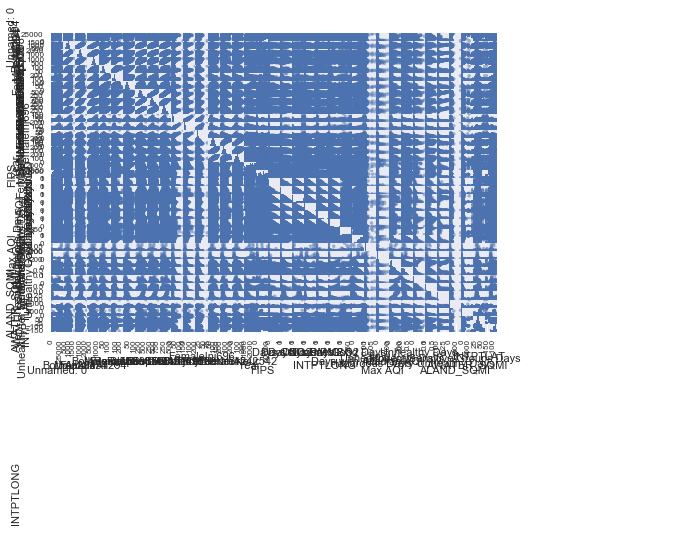

In [36]:
scatter_matrix(data)
plt.show()

In [37]:
def heatMap(df):
#Params: df - DataFrame of our Abalone data
#Return: Generates a heatmap plot

    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    #Generate Color Map, red & blue
    colormap = sn.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sn.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

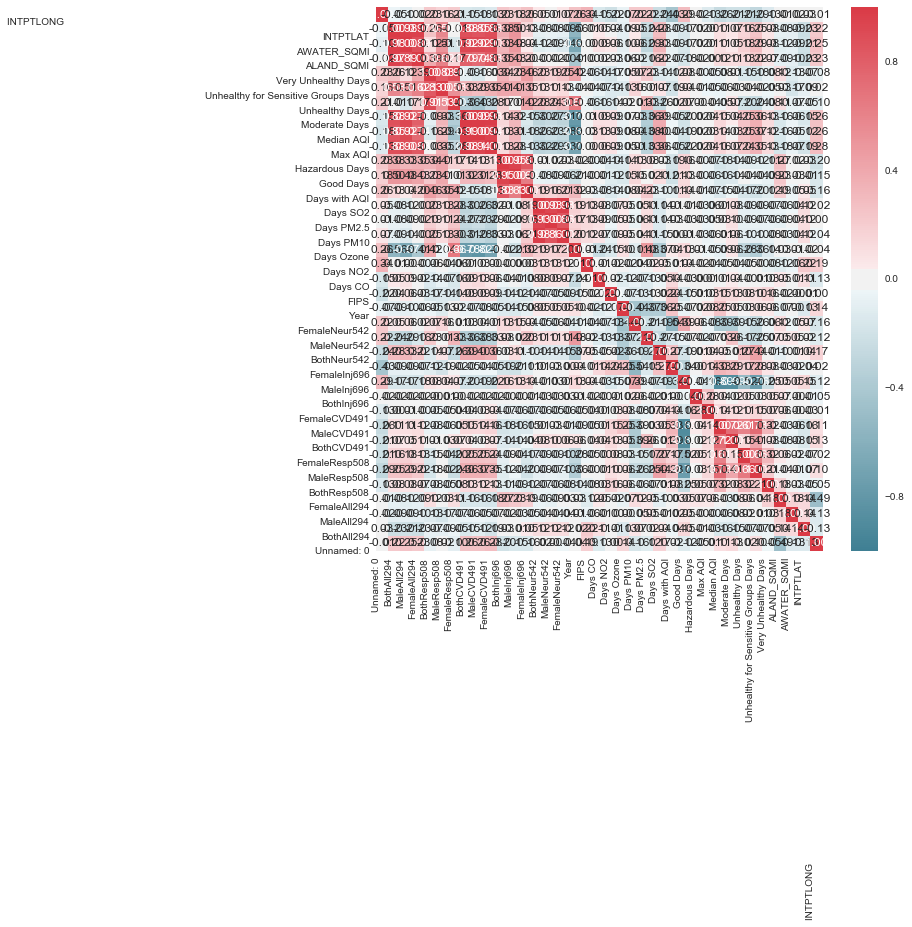

In [38]:
heatMap(big)

In [39]:
plt.show()


In [40]:
def halfHeatMap(df, mirror):

    # Create Correlation df
    corr = df.corr()
    # Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    # Generate Color Map
    colormap = sn.diverging_palette(220, 10, as_cmap=True)

    if mirror == True:
        #Generate Heat Map, allow annotations and place floats in map
        sn.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
        #Apply xticks
        plt.xticks(range(len(corr.columns)), corr.columns);
        #Apply yticks
        plt.yticks(range(len(corr.columns)), corr.columns)
        #show plot

    else:
        # Drop self-correlations
        dropSelf = np.zeros_like(corr)
        dropSelf[np.triu_indices_from(dropSelf)] = True# Generate Color Map
        colormap = sn.diverging_palette(220, 10, as_cmap=True)
        # Generate Heat Map, allow annotations and place floats in map
        sn.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
        # Apply xticks
        plt.xticks(range(len(corr.columns)), corr.columns);
        # Apply yticks
        plt.yticks(range(len(corr.columns)), corr.columns)
        #show plot
        plt.show()
    

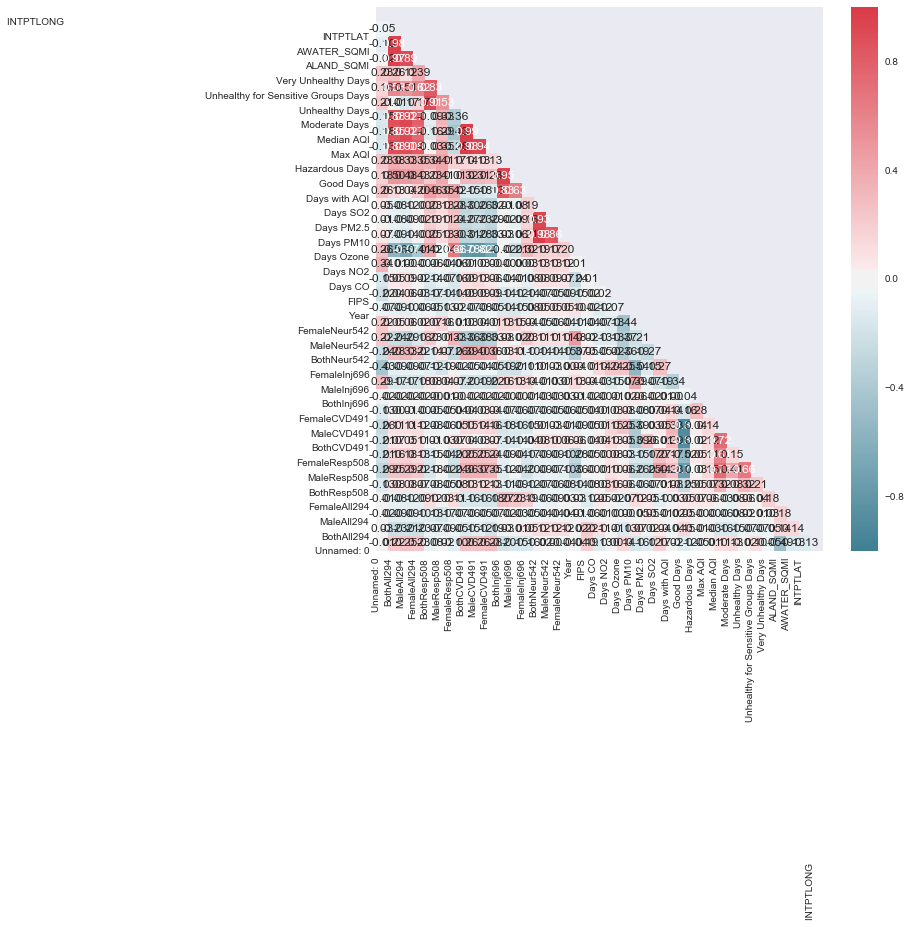

In [41]:
halfHeatMap(big, False)

In [42]:
data.head()


,Unnamed: 0,key,BothAll294,MaleAll294,FemaleAll294,BothResp508,MaleResp508,FemaleResp508,BothCVD491,MaleCVD491,...,Max AQI,Median AQI,Moderate Days,Unhealthy Days,Unhealthy for Sensitive Groups Days,Very Unhealthy Days,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,0,1980alabama_autauga,1216.628236,1679.098428,902.637168,46.561205,91.972862,20.019662,552.679686,753.862296,...,177,40,0.195531,0.022346,0.100559,0.000000,594.449,9.94,32.532237,-86.64644
1,1,1981alabama_autauga,1201.927171,1647.345926,902.781488,47.039097,92.487068,20.816786,541.074001,727.755510,...,195,32,0.137255,0.011204,0.042017,0.000000,594.449,9.94,32.532237,-86.64644
2,2,1982alabama_autauga,1177.720295,1633.414867,875.165224,46.745660,91.122103,21.091811,527.190244,718.834640,...,206,31,0.146939,0.000000,0.020408,0.004082,594.449,9.94,32.532237,-86.64644
3,3,1989alabama_autauga,1155.922891,1550.705770,895.821605,54.300125,95.239756,31.180085,474.887205,612.450341,...,100,34,0.142857,0.000000,0.000000,0.000000,594.449,9.94,32.532237,-86.64644
4,4,1990alabama_autauga,1158.116644,1574.322993,886.642029,55.547324,97.532618,32.003400,470.303348,616.890648,...,151,43,0.240602,0.003759,0.067669,0.000000,594.449,9.94,32.532237,-86.64644
